In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


from scipy.stats import skew, norm
from pandas_profiling import ProfileReport
from pathlib import Path, PurePath

np.random.seed(42)
%matplotlib inline

In [2]:
data_path = Path().resolve().parent/'data'

train_data = pd.read_csv(data_path/'train.csv')
train_data['ds'] = 'train'
test_data = pd.read_csv(data_path/'test.csv')
test_data['ds'] =  'test'

data = train_data.append([test_data])

target_columns = 'SalePrice'

In [3]:
print(data.shape, train_data.shape, test_data.shape, data['ds'].value_counts())
data.head()

(2919, 82) (1460, 82) (1459, 81) train    1460
test     1459
Name: ds, dtype: int64


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,ds
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,train
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,train
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,train
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,train
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,train


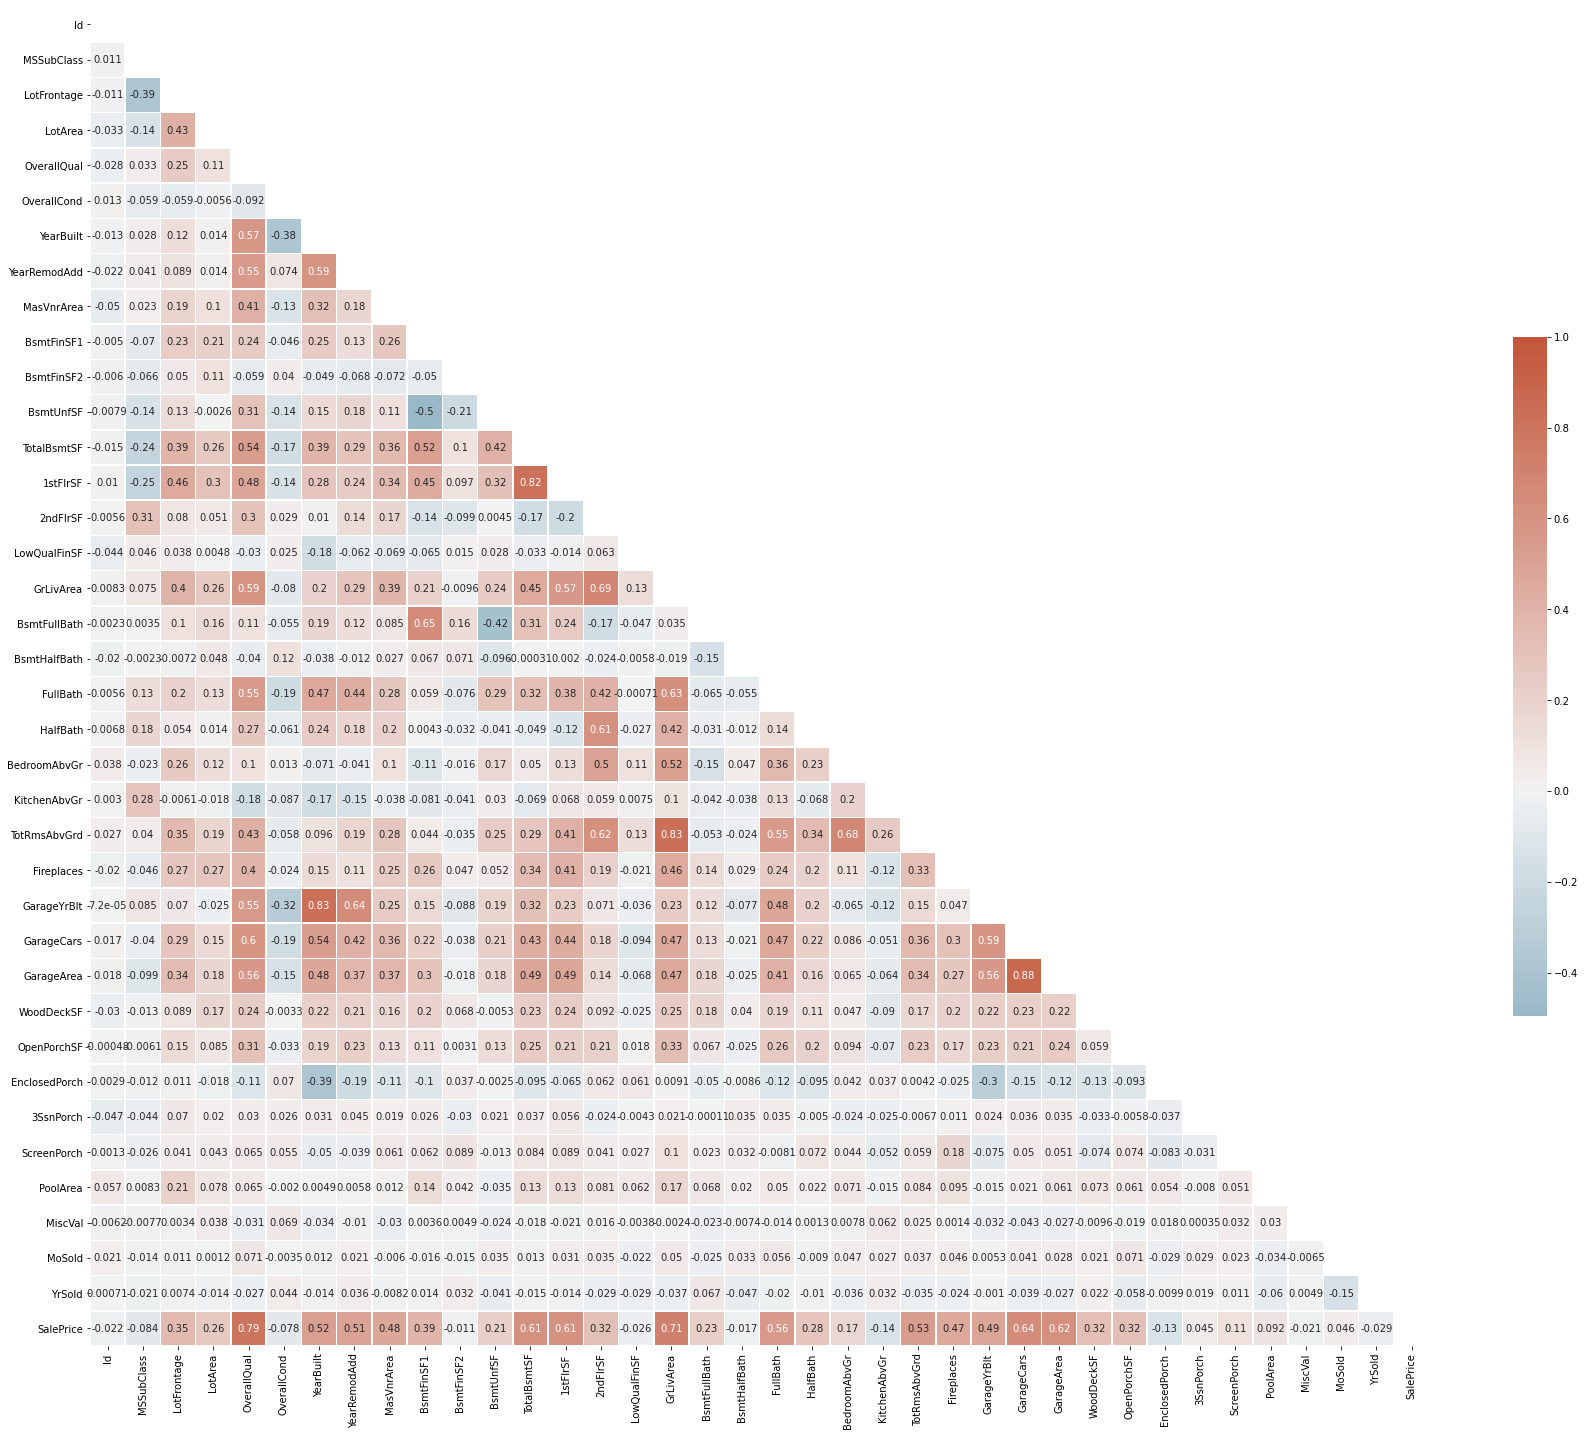

In [4]:
f, ax = plt.subplots(figsize=(30, 25))

mat = train_data.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

## Distribution checks

In [5]:
numeric_columns = list(mat.columns[1:-1].values)
categorical_columns = [col for col in data.columns if col not in list(mat.columns.values)][:-1]

### Numerical Dists

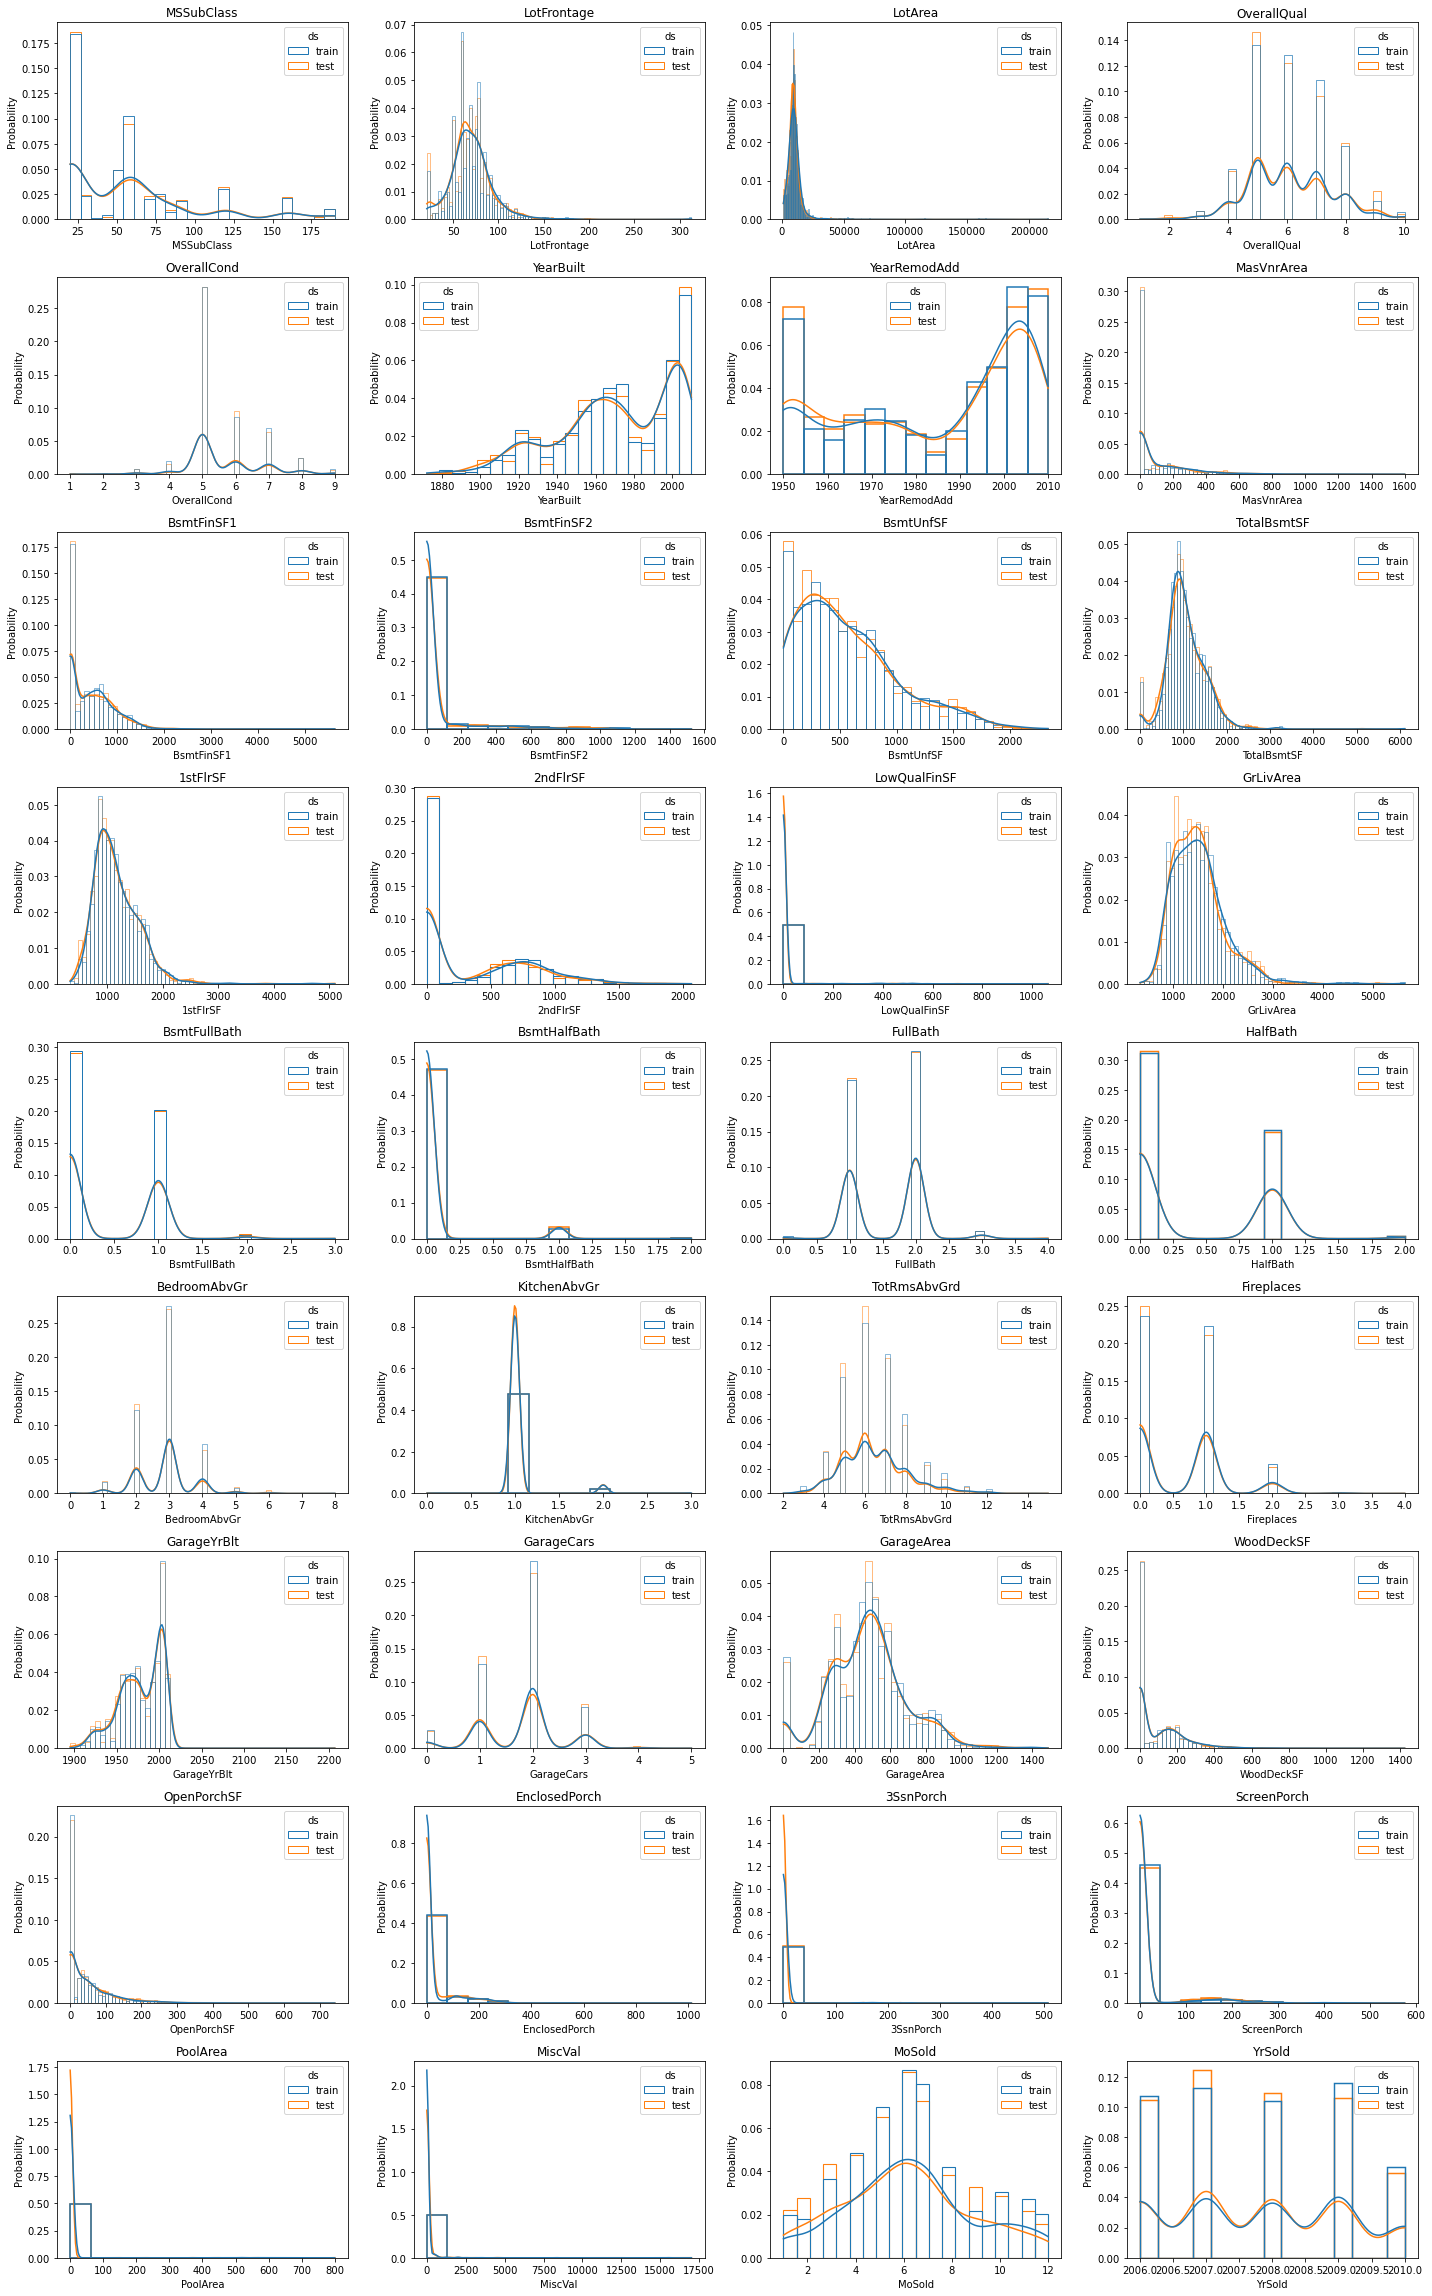

In [6]:
num_rows=9
num_cols=4
fig, ax = plt.subplots(num_rows, num_cols , figsize=(20, 32))
for row in range(num_rows):
    for col in range(num_cols):
        index=row*num_cols+col
        sns.histplot(x=numeric_columns[index], data=data, ax=ax[row][col], hue='ds', stat='probability', kde=True, fill=False).set_title(numeric_columns[index])

plt.tight_layout()      

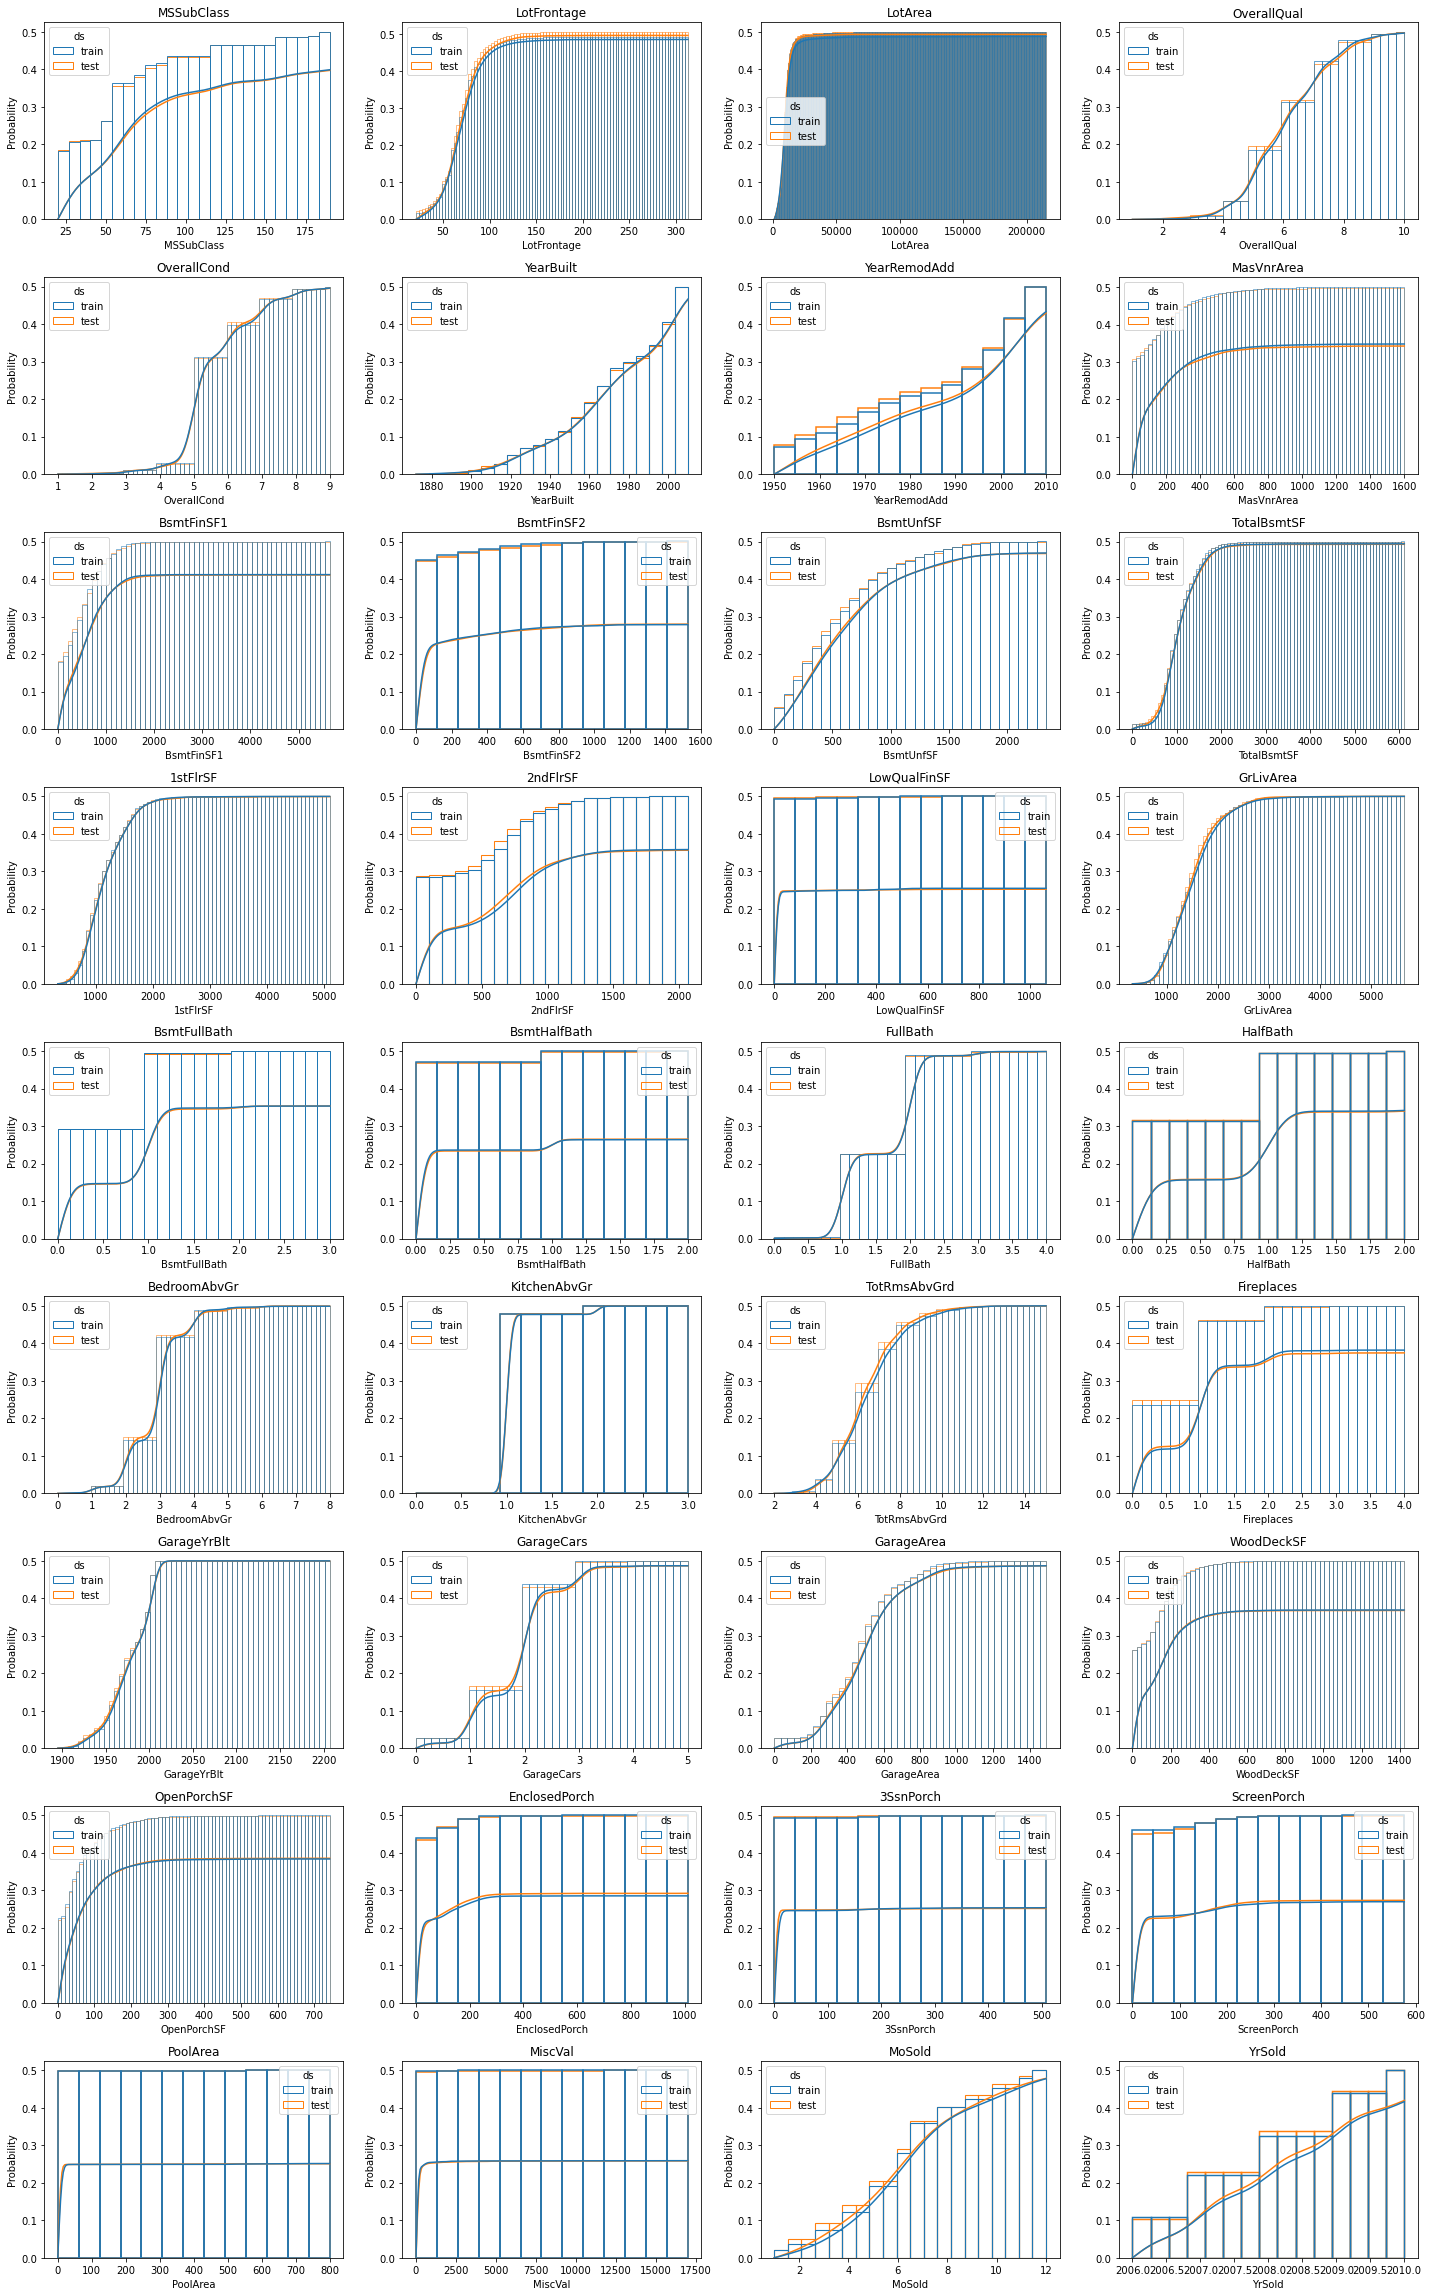

In [7]:
num_rows = 9
num_cols = 4
fig, ax = plt.subplots(num_rows, num_cols , figsize=(20, 32))
for row in range(num_rows):
    for col in range(num_cols):
        index = row*num_cols+col
        sns.histplot(x=numeric_columns[index], data=data, ax=ax[row][col], hue='ds', stat='probability', kde=True, fill=False, cumulative=True).set_title(numeric_columns[index])
plt.tight_layout()      

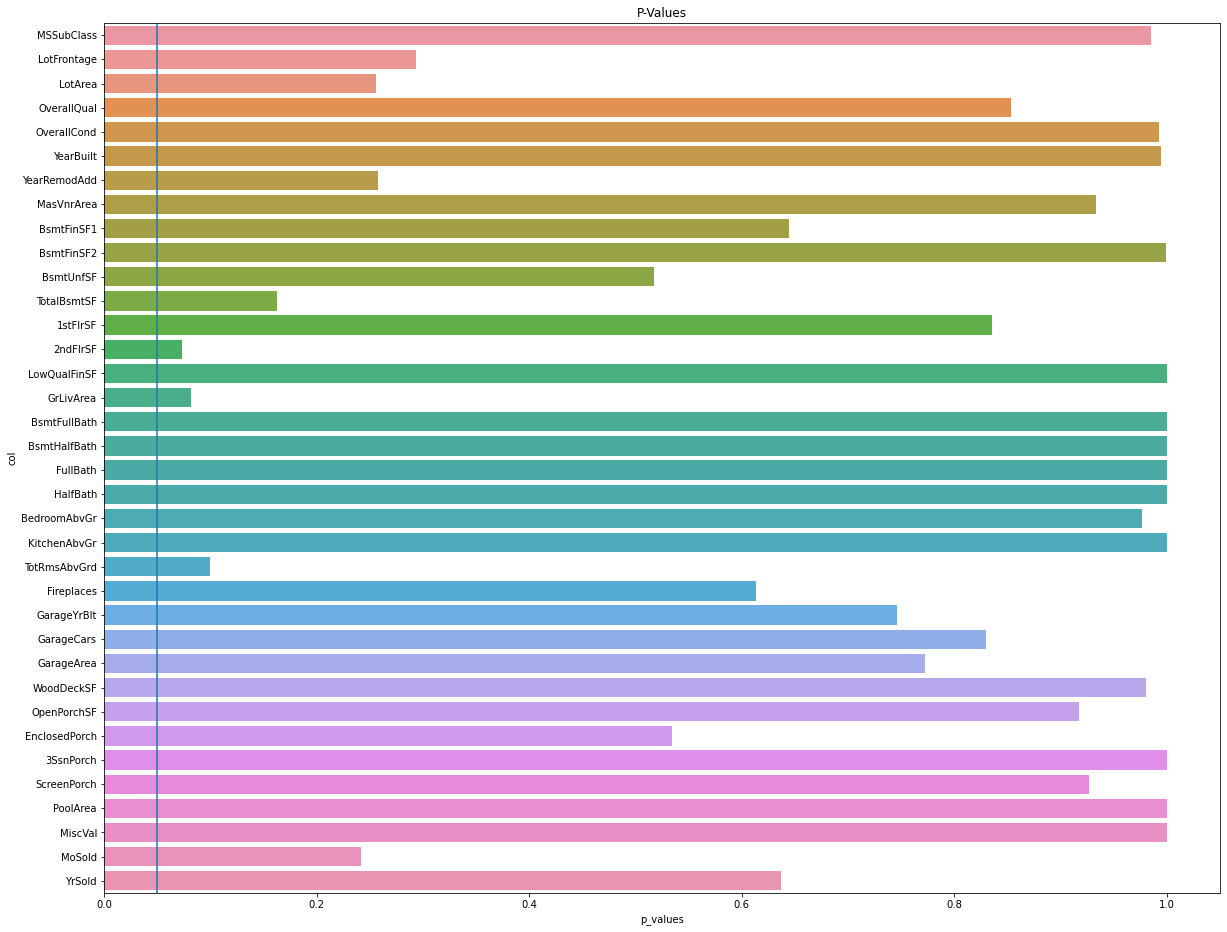

In [8]:
dist_diffs = {'col': [], 'p_values': []}
for ncol in numeric_columns: 
    dist_diffs['col'].append(ncol)
    dist_diffs['p_values'].append(stats.ks_2samp(data[data.ds=='train'][ncol], data[data.ds=='test'][ncol])[1])

plt.figure(figsize=(20, 16))
sns.barplot(y='col', x='p_values', data=pd.DataFrame(dist_diffs)).set_title("P-Values")
plt.axvline(0.05);

### Cateogorical Variables

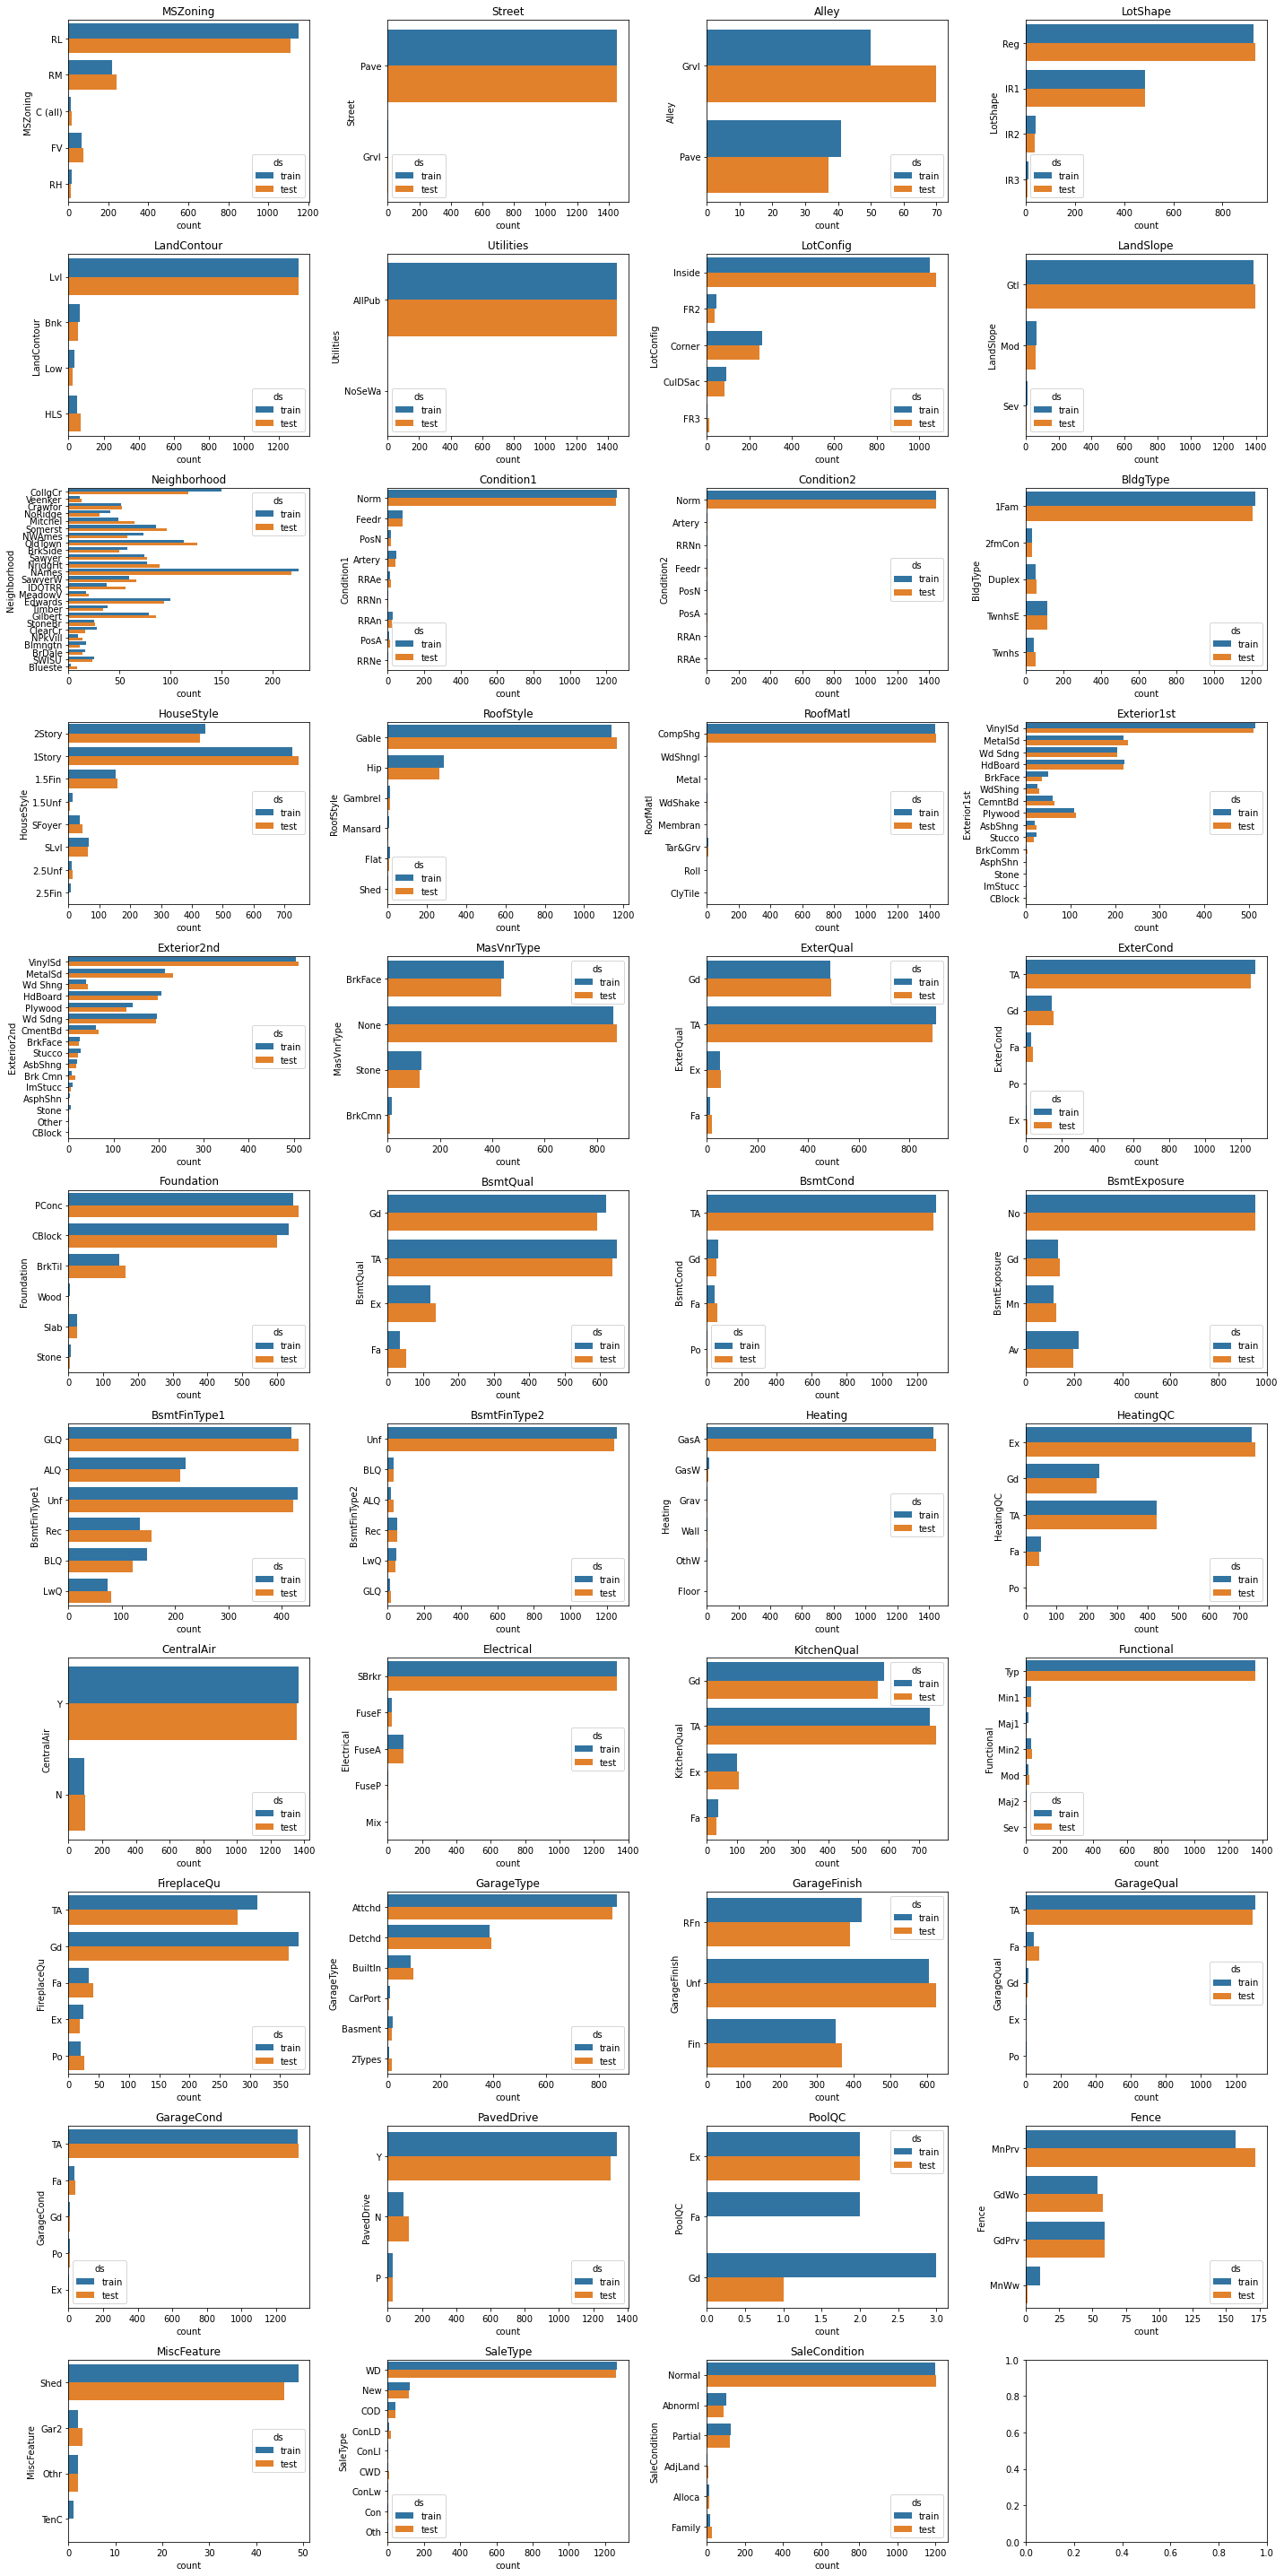

In [9]:
num_rows=11
num_cols=4
fig, ax = plt.subplots(num_rows, num_cols , figsize=(20, 40))
for row in range(num_rows):
    for col in range(num_cols):
        index=row*num_cols+col
        if index < len(categorical_columns):
            sns.countplot(y=categorical_columns[index], data=data, ax=ax[row][col], hue='ds').set_title(categorical_columns[index])

plt.tight_layout()     

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:6125: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


{'train_bigger': 10, 'test_bigger': 0, 'train_bigger_cols': ['Condition2', 'HouseStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Heating', 'Electrical', 'GarageQual', 'PoolQC', 'MiscFeature'], 'test_bigger_cols': []}


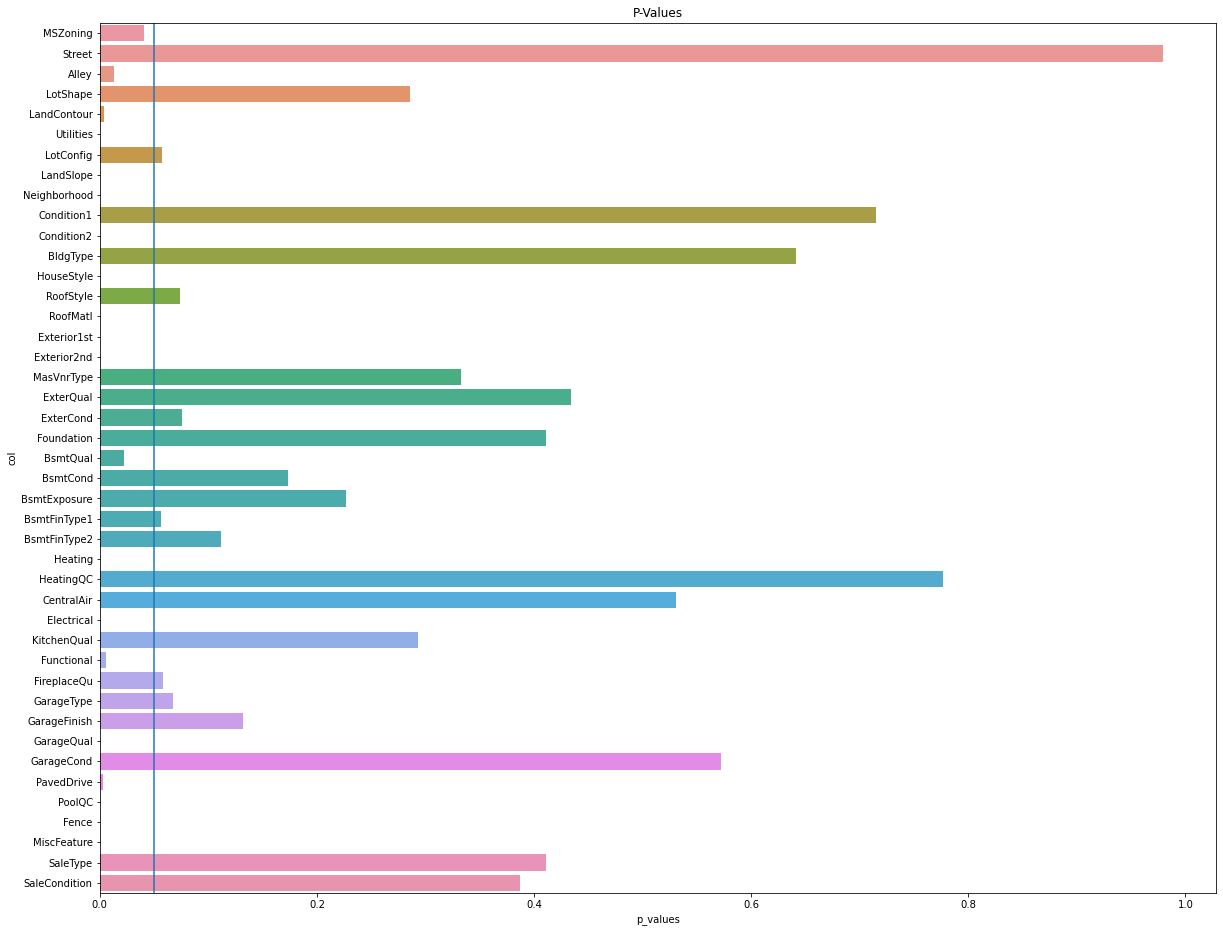

In [10]:
dist_diffs = {'col': [], 'p_values': []}
stats_dict = {"train_bigger": 0,
         "test_bigger": 0,
         "train_bigger_cols": [],
         "test_bigger_cols": []
        }

for ncol in categorical_columns: 
    dist_diffs['col'].append(ncol)
    train_freqs = data[data.ds=='train'][ncol].value_counts().sort_index()
    test_freqs = data[data.ds=='test'][ncol].value_counts().sort_index()
    try:
        dist_diffs['p_values'].append(
            stats.chisquare(train_freqs, test_freqs)[1]
        )
    except Exception as e:
        
        if train_freqs.shape[0] > test_freqs.shape[0]:
            stats_dict['train_bigger']+=1
            stats_dict['train_bigger_cols'].append(ncol)
            
            missing_cols = [mcol for mcol in train_freqs.index.values if  mcol not in test_freqs.index.values]
            for mcol in missing_cols:
                    test_freqs[mcol] = 0
        else:
            stats_dict['test_bigger']+=1
            stats_dict['test_bigger_cols'].append(ncol)
            
            missing_cols = [mcol for mcol in test_freqs.index.values if  mcol not in train_freqs.index.values]
            for mcol in missing_cols:
                    train_freqs[mcol] = 0

        dist_diffs['p_values'].append(
            stats.chisquare(train_freqs, test_freqs)[1]
        )
print(stats_dict)
plt.figure(figsize=(20, 16))
sns.barplot(y='col', x='p_values', data=pd.DataFrame(dist_diffs)).set_title("P-Values")
plt.axvline(0.05);

In [11]:
col_name = 'Electrical'
data[data.ds=='train'][col_name].value_counts().sort_index(), data[data.ds=='test'][col_name].value_counts().sort_index()

(FuseA      94
 FuseF      27
 FuseP       3
 Mix         1
 SBrkr    1334
 Name: Electrical, dtype: int64,
 FuseA      94
 FuseF      23
 FuseP       5
 SBrkr    1337
 Name: Electrical, dtype: int64)

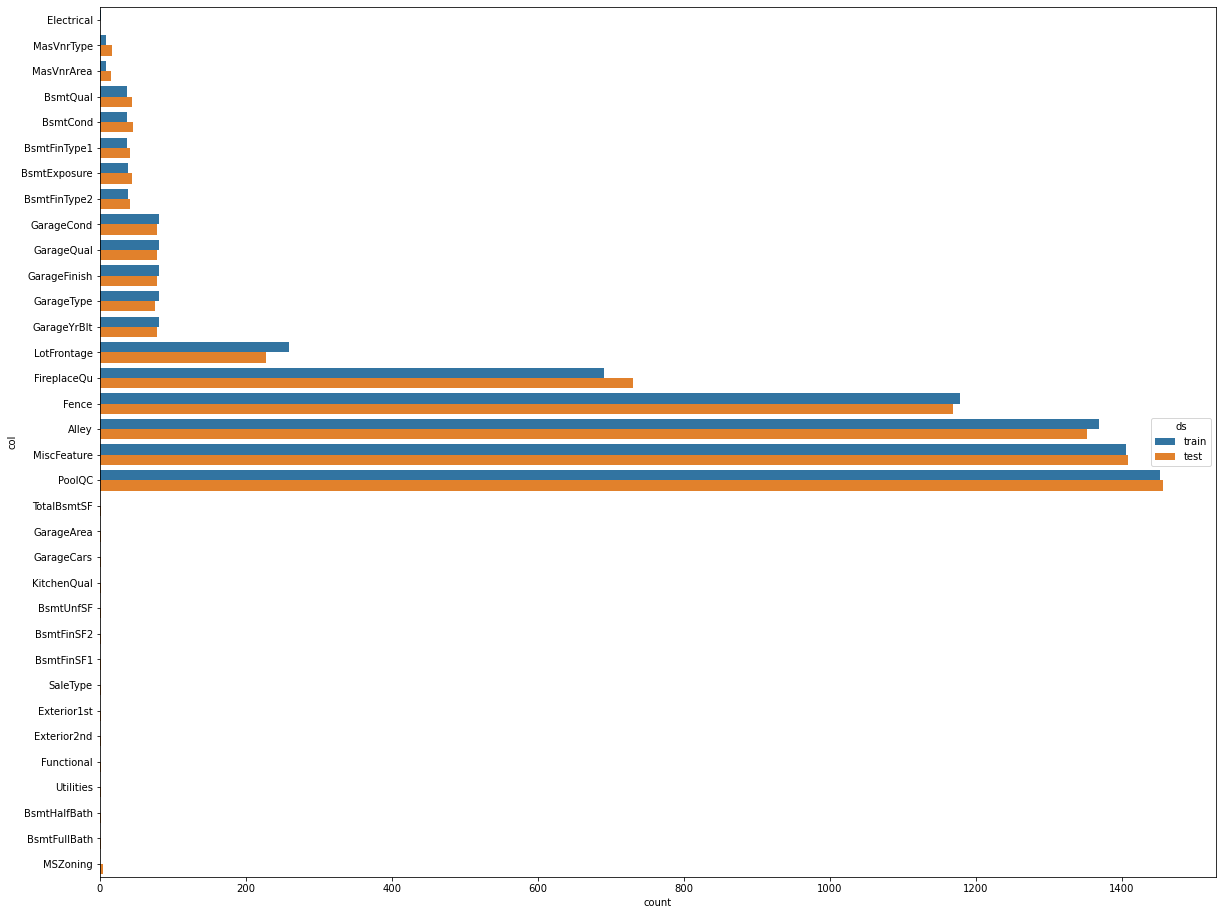

In [12]:
def count_missing(df, target):
    df = df.copy()
    df = df.drop(target, axis=1)
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)   
    missing = missing.to_frame().reset_index().rename(columns={'index': 'col', 0: 'count'})
    return missing

plt.figure(figsize=(20, 16))
train_missing = count_missing(data[data.ds=='train'], 'SalePrice')
train_missing['ds'] = 'train'
test_missing = count_missing(data[data.ds=='test'], 'SalePrice')
test_missing['ds'] = 'test'
missing_data = train_missing.append([test_missing])

sns.barplot(x='count', y='col', hue='ds', data=missing_data);


### Target Variable

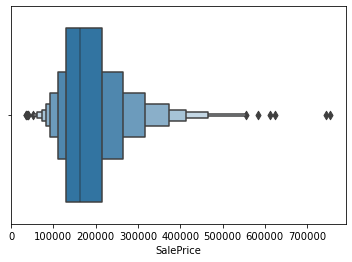

In [20]:
sns.boxenplot(x=target_columns, data=data[data.ds=='train'],  hue='YrSold');

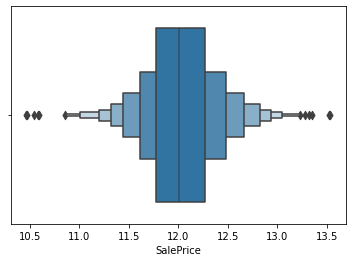

In [16]:
sns.boxenplot(x=np.log(data[data.ds=='train'][target_columns]));

In [18]:
plt.figure(figsize=(20,16))
sns.histplot(np.log(data[data.ds=='train'][target_columns]), kde=True);

SyntaxError: invalid syntax (<ipython-input-18-ca7f13e795f1>, line 2)